In [2]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
import t4utils as t4

%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

Summary of steps to implement a deep neural network model:

1. Initialize the parameters of a $K$-layer neural network.
2. Implement the forward propagation:
    - compute linear component $z^{[k]}=a^{[k-1]} W^{[k]} + b^{[k]}$
    - compute activation $a^{[k]} = g(z^{[k]})$, where $g(\cdot)$ is the layer non-linearity (activation function). I'll use both ReLU and sigmoid.
    - combine $K-1$ ReLU layers with a final sigmoid layer ($K$ layer in total)
    - compute all layer outputs
    - evaluate loss from final layer activation
3. Implement the backward propagation:
    - compute the gradients for the linear component and the non-linear activation function
    - perform backprop on sigmoid layer followed by $K-1$ ReLU layers
    - evaluate gradients for all parameters $W^{[k]}, b^{[k]}$
4. Update parameters using learning rate

To implement our learning algorithm, we will associate a backprop module for every forward function. At every step of your 
forward evaluation, we will store results in a cache required to compute gradients during backprop. As a result, training a network using backprop requires about twice more memory than inference. With deep learning frameworks, your generally describe your network as graph and differentiation is performed automatically for training model parameters.

## A. Load Dataset and Initialise Model ##

First, generating a dataset to work on. We will use the `catsvsnoncats` image dataset used in the logistic regression notebook.


In [3]:
def load_dataset(filepath='datasets/catsvsnoncats.h5'):
    """
    Load and pre-process dataset
    
    Arguments:
    filepath -- string, dataset path

    Returns:
    (X_train, Y_train), (X_test, Y_test), classes -- training and test datasets
    """

    h5file = h5py.File(filepath, "r")
    X_train = np.array(h5file["X_train"][:])
    Y_train = np.array(h5file["Y_train"][:])
    X_test = np.array(h5file["X_test"][:])
    Y_test = np.array(h5file["Y_test"][:])
    classes = np.array(h5file["Classes"][:]) 
    h5file.close()

    # Reshape and scale datasets containing N_train and N_test mages such that
    # X_train.shape = (n_train, W * H * 3)
    # Y_train.shape = (n_train, 1)
    # X_test.shape = (n_test, W * H * 3)
    # X_test.shape = (n_test, 1)
    # Scale X_train and X_test from range {0..255} to (0,1)
    
    X_train = X_train.reshape(X_train.shape[0],-1)/255
    X_test = X_test.reshape(X_test.shape[0],-1)/255
    Y_train = Y_train.reshape(Y_train.shape[0],1)
    Y_test = Y_test.reshape(Y_test.shape[0],1)

    return (X_train, Y_train), (X_test, Y_test), classes

Configuring the model topology i.e. K-1 ReLU activated layers and one final sigmoid activated layer. Initialise bias to zeros and weights from $\mathcal{N}(0,\sigma)$ with $\sigma = 1 /\sqrt{n_h^{[k]}}$ where $n_h^{[k]}$ is number of units in the $k$-th layer.

The number of units of the first layer is determined by the number of features of our dataset, $x$. Similarly the number of units of the final output layer is determined by the dimension of $y$. The number of units for the remaining $K-1$ hidden layers is specified as an array of integers.

 Setup the model topology


In [4]:
def model_config(X, Y, n_h=[128, 64, 16, 8]):
    """
    Arguments:
    X -- n data samples, shape = (n, n_x)
    Y -- ground truth label, column vector of shape (n, n_y)
    n_h -- array with number of units in hidden layers, size K-1
    
    Returns:
    params -- dictionary containing initialised model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised bias vector of shape (1, n_h1)
        ...
        Wk -- initialised weight matrix of shape (n_hk-1, n_hk)
        bk -- initialised bias vector of shape (1, n_hk)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised bias vector of shape (1, n_y)
    """
    
    n_x = X.shape[1] # size of input layer
    n_y = Y.shape[1] # size of output layer
    
    dims = sum([[n_x], n_h, [n_y]], [])
    K = len(dims) # number of network layers

    params = {}
    
    for k in range(1, K):
        params['W{}'.format(k)] = np.random.randn(dims[k-1],dims[k])/np.sqrt(dims[k - 1])
        params['b{}'.format(k)] = np.zeros((1,dims[k]))
                                                    
        assert(params['W{}'.format(k)].shape == (dims[k - 1], dims[k]))
        assert(params['b{}'.format(k)].shape == (1, dims[k]))

    assert(X.shape[0] == (Y.shape[0]))
    return params

In [5]:
X, Y, n_h = t4.model_config_test()
params = model_config(X, Y, [3])
for k in range(1, len(params) // 2 + 1):
    print("W{} = {}".format(k, params['W{}'.format(k)]))
    print("b{} = {}".format(k, params['b{}'.format(k)]))

W1 = [[ 0.9195  -0.21968  0.58   ]
 [-0.28855 -0.51552 -0.41944]
 [ 0.15847  0.17663  0.75786]
 [-0.18893 -0.54634 -0.32417]]
b1 = [[0. 0. 0.]]
W2 = [[ 0.85447 -1.2155 ]
 [ 0.13204  0.20821]
 [-0.83132 -0.38261]]
b2 = [[0. 0.]]


In [6]:
# Forward propagation for linearity
def linear_fwd(W, b, A):
    """
    Linearity

    Arguments:
    W -- weight matrix, shape (n_hk-1, n_hk)
    b -- bias row vector, shape (1, n_hk)
    A -- input, shape (n, n_hk-1)

    Returns:
    Z -- linear output, shape (n, n_hk)
    cache -- dictionary for back propagation
        W -- weight matrix
        b -- bias row vector
        A_prev -- input
    """
    
    Z = A @ W + b
    cache = {'W':W, 'b':b, 'A_prev':A}
    
    assert(Z.shape == (A.shape[0], W.shape[1]))
    return Z, cache

# Forward propagation for sigmoid non-linearity
def sigmoid_fwd(Z):
    """
    Sigmoid activation
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(Z), same shape as Z
    cache -- dictionary for backpropagation
        Z -- activation's input
    """

    A = 1/(1 + np.exp(-Z))
    cache = {'Z':Z}
    
    assert(A.shape == Z.shape)
    return A, cache

# Forward propagation for ReLU non-linearity
def relu_fwd(Z):
    """
    RELU activation

    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of ReLU(Z), same shape as Z
    cache -- dictionary for backpropagation
        Z -- activation's input
    """
    
    A = np.maximum(0, Z)
    cache = {'Z':Z}
    
    assert(A.shape == Z.shape)
    return A, cache

In [7]:
W, b, A = t4.linear_fwd_test()
Z, cache = linear_fwd(W, b, A)
print("Z.T = {}".format(Z.T))
A, cache = relu_fwd(Z)
print("A.T = ReLU(Z.T) = {}".format(A.T))
A, cache = sigmoid_fwd(Z)
print("A.T = sigmoid(Z.T) = {}".format(A.T))

Z.T = [[0.71591 1.45199]]
A.T = ReLU(Z.T) = [[0.71591 1.45199]]
A.T = sigmoid(Z.T) = [[0.67171 0.8103 ]]


In [8]:
# Single layer forward propagation for 
def singlelayer_fwd(W, b, A_prev, non_linearity='ReLU'):
    """
    Single layer forward propagation (linear + non-linearity)

    Arguments:
    W -- weight matrix, shape (n_hk-1, n_hk)
    b -- bias row vector, shape (1, n_hk)
    A_prev -- input, shape (n, n_hk-1)
    non_linearity -- string ('ReLU' or 'Sigmoid') activation for layer
    
    Returns:
    A -- output of g(A_prev @ W + b), shape (n, n_hk)
    cache -- dictionary for backprop
        LINEAR -- dictionary linear cache
        ACTIVATION -- dictionary activation cache        
    """
    
    Z, linear_cache = linear_fwd(W,b,A_prev)
    
    if non_linearity == 'ReLU':
        A, activation_cache = relu_fwd(Z)
    elif non_linearity == 'Sigmoid':
        A, activation_cache = sigmoid_fwd(Z)
    
    assert(A.shape == (A_prev.shape[0], W.shape[1]))
    return A, {'LINEAR': linear_cache, 'ACTIVATION': activation_cache}

In [9]:
W, b, A_prev = t4.singlelayer_fwd_test()
A, cache = singlelayer_fwd(W, b, A_prev, 'Sigmoid')
print("A_Sigmoid.T = {}".format(A.T))
print("cache = {}".format(cache))
A, cache = singlelayer_fwd(W, b, A_prev, 'ReLU')
print("A_ReLU.T = {}".format(A.T))
print("cache = {}".format(cache))

A_Sigmoid.T = [[0.67171 0.8103 ]]
cache = {'LINEAR': {'W': array([[ 0.57376],
       [ 0.28773],
       [-0.23563]]), 'b': array([[0.95349]]), 'A_prev': array([[-0.21768,  0.82146,  1.48128],
       [ 1.33186, -0.36187,  0.68561]])}, 'ACTIVATION': {'Z': array([[0.71591],
       [1.45199]])}}
A_ReLU.T = [[0.71591 1.45199]]
cache = {'LINEAR': {'W': array([[ 0.57376],
       [ 0.28773],
       [-0.23563]]), 'b': array([[0.95349]]), 'A_prev': array([[-0.21768,  0.82146,  1.48128],
       [ 1.33186, -0.36187,  0.68561]])}, 'ACTIVATION': {'Z': array([[0.71591],
       [1.45199]])}}


In [10]:
# Forward propagation (inference)
def forward_prop(params, X, Y=None):
    """
    Compute the layer activations and loss if needed

    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    X -- n data samples, shape = (n, n_x)
    Y -- optional argument, ground truth label, column vector of shape (n, n_y)

    Returns:
    A -- final layer output (activation value) 
    loss -- cross-entropy loss or NaN if Y=None
    caches -- array of caches for the K layers
    """
    
    caches = []
    K = len(params) >> 1
    A = X
    
    # K-1 [Linear->ReLU] layer
    for k in range(1, K):
        A_prev = A
        W = params['W{}'.format(k)]
        b = params['b{}'.format(k)]
        A, cache = singlelayer_fwd(W,b,A_prev)
        caches.append(cache)

    # 1 [Linear->Sigmoid] layer
    A_prev = A
    W = params['W{}'.format(K)]
    b = params['b{}'.format(K)]
    A, cache = singlelayer_fwd(W, b, A_prev,'Sigmoid')
    caches.append(cache)
    
    loss = float('nan')
    if Y is not None:
        Y_hat = A
        n = Y.shape[0]
        # Compute the cross-entropy loss
        loss = -(1/n)*np.sum(Y*np.log(Y_hat) + (1-Y)*np.log(1-Y_hat))

        loss = np.squeeze(loss)
        assert(loss.dtype == float)
        
    assert(A.shape == (X.shape[0], W.shape[1]))
    return A, loss, caches

In [11]:
X, Y, params = t4.forward_prop_test()
A, loss, caches = forward_prop(params, X, Y)
print("A.T = {}".format(A.T))
print("loss = {:.5f}".format(loss))
print("{} caches".format(len(caches)))

A.T = [[0.10101 0.33321 0.01484 0.00042]]
loss = 0.67831
3 caches


In [12]:
# Backward propagation for linearity
def linear_back(dZ, cache):
    """
    Linearity backprop

    Arguments:
    dZ -- gradient of loss with respect to current layer linear output
    cache -- dictionary from forward propagation
        W -- weight matrix
        b -- bias row vector
        A_prev -- previous layer activation input

    Returns:
    dW -- gradient of loss with respect to current layer weights
    db -- gradient of loss with respect to current layer bias
    dA_prev -- gradient of loss with respect to activation of previous layer output
    """

    W = cache['W']
    b = cache['b']
    A_prev = cache['A_prev']
    n = A_prev.shape[0]
    dW = (1/n)*A_prev.T @ dZ
    db = (1/n)*np.sum(dZ, axis=0, keepdims=True)
    dA_prev = dZ @ W.T
    
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    assert(dA_prev.shape == A_prev.shape)
    
    return dW, db, dA_prev

# Backward propagation for ReLU non-linearity
def relu_back(dA, cache):
    """
    ReLU backprop

    Arguments:
    dA -- gradient of loss with respect to activation
    cache -- dictionary from forward propagation
        Z -- layer linearity output 

    Returns:
    dZ -- gradient of loss with respect to Z
    """
    
    Z = cache['Z']
    dZ = np.array(dA,copy=True)
    dZ[Z<=0]=0
    
    assert(dZ.shape == Z.shape)
    return dZ

# Backward propagation for sigmoid non-linearity
def sigmoid_back(dA, cache):
    """
    Sigmoid backprop

    Arguments:
    dA -- gradient of loss with respect to activation
    cache -- dictionary from forward propagation
        Z -- layer linearity output 

    Returns:
    dZ -- gradient of loss with respect to Z
    """
    
    Z = cache['Z']
    S = 1/(1+np.exp(-Z))
    dZ = dA*S*(1-S)
    
    assert(dZ.shape == Z.shape)
    return dZ

In [13]:
dZ, cache = t4.linear_back_test()
dW, db, dA_prev = linear_back(dZ, cache)
print("dW.T = {}".format(dW.T))
print("db = {}".format(db))
print("dA_prev = {}".format(dA_prev))
A, cache = t4.non_linearity_test()
dZ = relu_back(A, cache)
print("ReLU: dZ = {}".format(dZ))
dZ = sigmoid_back(A, cache)
print("Sigmoid: dZ = {}".format(dZ))

dW.T = [[0.12038 0.0907  0.15756]]
db = [[0.30189]]
dA_prev = [[ 0.05129 -0.20755  0.3678 ]
 [-0.19356  0.78325 -1.38795]]
ReLU: dZ = [[-0.21768  0.82146  0.     ]
 [ 1.33186  0.       0.     ]]
Sigmoid: dZ = [[-0.05018  0.20117  0.36523]
 [ 0.26743 -0.0476   0.1664 ]]


In [14]:
def singlelayer_back(dA, cache, non_linearity='ReLU'):
    """
    Single layer backprop (linear + non-linearity)

    Arguments:
    dA -- gradient of loss with respect to activation
    cache -- dictionary from forward propagation
        LINEAR -- dictionary from forward linear propagation 
        ACTIVATION -- dictionary from forward non-linearity propagation 
    non_linearity -- string ('ReLU' or 'Sigmoid') activation for layer

    Returns:
    dW -- gradient of loss with respect to current layer weights
    db -- gradient of loss with respect to current layer bias
    dA_prev -- gradient of loss with respect to activation of previous layer output
    """
    
    linear_cache = cache['LINEAR']
    activation_cache = cache['ACTIVATION']
    
    if non_linearity == 'Sigmoid':
        dZ = sigmoid_back(dA, activation_cache)
    elif non_linearity == 'ReLU':
        dZ = relu_back(dA, activation_cache)
        
    dW, db, dA_prev = linear_back(dZ, linear_cache)
    
    return dW, db, dA_prev

In [15]:
dA, cache = t4.singlelayer_back_test()

dW, db, dA_prev = singlelayer_back(dA, cache, 'ReLU')
print("ReLU: dW.T = {}".format(dW.T))
print("ReLU: db = {}".format(db))
print("ReLU: dA_prev = {}".format(dA_prev))

dW, db, dA_prev = singlelayer_back(dA, cache, 'Sigmoid')
print("Sigmoid: dW.T = {}".format(dW.T))
print("Sigmoid: db = {}".format(db))
print("Sigmoid: dA_prev = {}".format(dA_prev))

ReLU: dW.T = [[-0.16122 -0.14496  0.03939]]
ReLU: db = [[-0.10884]]
ReLU: dA_prev = [[ 0.05129 -0.20755  0.3678 ]
 [ 0.       0.       0.     ]]
Sigmoid: dW.T = [[0.02563 0.01894 0.03751]]
Sigmoid: db = [[0.06896]]
Sigmoid: dA_prev = [[ 0.01282 -0.05188  0.09194]
 [-0.04532  0.18338 -0.32496]]


In [16]:
# Backward_propagation
def back_prop(AK, Y, caches):
    """
    Compute back-propagation gradients
    
    Arguments:
    AK -- probability vector, final layer output, shape (1, n_y)
    Y -- ground truth output (n, n_y)
    caches -- array of layer cache, len=K
    
    Returns:
    grads -- dictionary containing your gradients with respect to all parameters
        dW1 -- weight gradient matrix of shape (n_x, n_h1)
        db1 -- bias gradient vector of shape (1, n_h1)
        ...
        dWK -- weight gradient matrix of shape (n_hK-1, n_y)
        dbK -- bias gradient vector of shape (1, n_y)
    """
    
    grads = {}
    K = len(caches)
    n = AK.shape[0]
    assert(Y.shape == AK.shape)

    dAK = -((Y/AK) - ((1-Y) / (1-AK)))
    cache = caches[K-1] 
    grads["dW{}".format(K)], grads["db{}".format(K)],  grads["dA{}".format(K)] = singlelayer_back(dAK, cache, non_linearity='Sigmoid')
    
    for k in reversed(range(K - 1)):
        cache = caches[k]
        grads["dW{}".format(k + 1)], grads["db{}".format(k + 1)], grads["dA{}".format(k + 1)] = singlelayer_back(grads["dA{}".format(k+2)], cache)
        
    return grads

In [17]:
AK, Y, caches = t4.back_prop_test()
grads = back_prop(AK, Y, caches)
print("dW1.T = {}".format(grads['dW1'].T))
print("db1 = {}".format(grads['db1']))
print("dA1 = {}".format(grads['dA1']))
print("dW2.T = {}".format(grads['dW2'].T))
print("db2 = {}".format(grads['db2']))
print("dA2 = {}".format(grads['dA2']))

dW1.T = [[ 0.39632  0.35635 -0.09682  0.18344]
 [ 0.71849  0.64602 -0.17552  0.33255]
 [ 0.16057  0.14437 -0.03923  0.07432]]
db1 = [[0.26756 0.48505 0.1084 ]]
dA1 = [[-1.2351  -0.07942  2.06421 -1.18989]
 [ 0.       0.       0.       0.     ]]
dW2.T = [[-0.68133  0.1135  -0.30305]]
db2 = [[0.86059]]
dA2 = [[0.53511 0.9701  0.2168 ]
 [0.47488 0.86091 0.1924 ]]


In [18]:
# Update model parameters
def update_params(params, grads, learning_rate=0.8):
    """
    Updates parameters using the gradient descent
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    grads -- dictionary containing gradients
        dW1 -- weight gradient matrix of shape (n_x, n_h1)
        db1 -- bias gradient vector of shape (1, n_h1)
        ...
        dWK -- weight gradient matrix of shape (n_hK-1, n_y)
        dbK -- bias gradient vector of shape (1, n_y)
    learning_rate -- learning rate of the gradient descent (hyperparameter)

    Returns:
    params -- dictionary containing updated parameters
    """

    K = len(params) >> 1
    for k in range(1, K + 1):
        params['W{}'.format(k)] = params['W{}'.format(k)] - learning_rate*grads['dW{}'.format(k)]
        params['b{}'.format(k)] = params['b{}'.format(k)] - learning_rate*grads['db{}'.format(k)]
    
    return params

In [19]:
params, grads = t4.update_params_test()
params = update_params(params, grads, 0.1)
print("W1.T = {}".format(params['W1'].T))
print("b1 = {}".format(params['b1']))
print("W2.T = {}".format(params['W2'].T))
print("b2 = {}".format(params['b2']))

W1.T = [[-0.39654  1.51821  0.58204  1.00121]
 [ 0.7778  -0.33413  0.35043 -1.55824]
 [ 1.47163  0.72108 -0.23125 -0.4334 ]]
b1 = [[-0.07123 -0.68594  0.23951]]
W2.T = [[-0.14884  2.72671  0.61945]]
b2 = [[0.74769]]


In [20]:
# Parameter optimisation using backprop
def model_fit(params, X, Y, epochs=2500, learning_rate=0.0075, verbose=False):
    """
    Optimise model parameters by performing gradient descent
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    X -- n data samples  (n, n_x)
    Y -- groud truth label vector of size (n, n_y)
    epochs -- number of iteration updates through dataset
    learning_rate -- learning rate of the gradient descent
    
    Returns:
    params -- dictionary with optimised parameters
    grads -- dictionary with final gradients
    loss_log -- list of loss values for every 100 updates
    """
    
    loss_log = []
    for i in range(epochs):
        A, loss, caches = forward_prop(params,X,Y)
        grads = back_prop(A,Y,caches)
        params = update_params(params,grads,learning_rate)
        
        # logs
        if i % 100 == 0:
            loss_log.append(loss.item())
            if verbose:
                print("Loss after {} epochs: {:.3f}".format(i, loss))
     
    return params, grads, loss_log

In [21]:
X, Y, params = t4.forward_prop_test()
params, grads, loss_log = model_fit(params, X, Y, epochs = 300, verbose=False)
print("loss = {}".format(np.array(loss_log)))
print("W1.T = {}".format(params['W1'].T))
print("b1 = {}".format(params['b1']))
print("W2.T = {}".format(params['W2'].T))
print("b2 = {}".format(params['b2']))
print("W3.T = {}".format(params['W3'].T))
print("b3 = {}".format(params['b3']))
print("dW1.T = {}".format(grads['dW1'].T))
print("db1 = {}".format(grads['db1']))
print("dW2.T = {}".format(grads['dW2'].T))
print("db2 = {}".format(grads['db2']))
print("dW3.T = {}".format(grads['dW3'].T))
print("db3 = {}".format(grads['db3']))



loss = [0.67831 0.39311 0.38196]
W1.T = [[-0.93729  0.72484 -0.71946  0.90889 -0.95217]
 [ 0.06497  0.47414 -0.83891  0.21742  0.58681]
 [-3.22537  0.40678 -0.81217 -1.18205  1.06676]
 [ 1.02805  0.46416 -0.46209 -0.91687  0.2003 ]]
b1 = [[-0.89367 -0.9791  -1.53733 -1.24609]]
W2.T = [[ 0.33411 -0.79252  1.2068  -0.83628]
 [-0.17309  1.839   -0.57709  0.31693]
 [ 1.46725 -0.43936 -1.03104  0.35325]]
b2 = [[ 1.44688 -0.37785 -1.12293]]
W3.T = [[-0.48626  1.47999 -2.10593]]
b3 = [[0.35461]]
dW1.T = [[-0.00422  0.00449  0.03353  0.02765 -0.00591]
 [ 0.       0.       0.       0.       0.     ]
 [ 0.01105  0.00226 -0.00011  0.00337 -0.0016 ]
 [ 0.       0.       0.       0.       0.     ]]
db1 = [[ 0.01863  0.      -0.00654  0.     ]]
dW2.T = [[ 0.02712  0.      -0.02508  0.     ]
 [ 0.       0.       0.       0.     ]
 [-0.00808  0.       0.       0.     ]]
db2 = [[ 0.01661  0.      -0.00378]]
dW3.T = [[-0.00584  0.       0.00361]]
db3 = [[-0.03416]]


In [22]:
# Model inference
def model_predict(params, X):
    """
    Predict class label using model parameters
    
    Arguments:
    params -- dictionary containing model parameters
        W1 -- initialised weight matrix of shape (n_x, n_h1)
        b1 -- initialised weight matrix of shape (1, n_h1)
        ...
        WK -- initialised weight matrix of shape (n_hK-1, n_y)
        bK -- initialised weight matrix of shape (1, n_y)
    X -- n data samples, shape (n, n_x)
    
    Returns:
    Y_hat -- vector with class predictions for examples in X, shape (n, n_y)
    """
        
    AK, _, _ = forward_prop(params, X)
    Y_hat = (AK > 0.5)*1 # Convert activations to {0,1} predictions
        
    n = X.shape[0]
    assert(Y_hat.shape == (n, 1))    
    return Y_hat

In [23]:
X, _, params = t4.forward_prop_test()
params['b1'] = np.zeros((1,4))
Y_hat = model_predict(params, X)
print("predictions.T = {}".format(Y_hat.T))

predictions.T = [[0 1 0 0]]


In [27]:
# Deep model
def deep_model(X_train, Y_train, X_test, Y_test, hidden_layers=[21, 7, 3], epochs=2500, learning_rate=0.007, verbose=True):
    '''
    Build, train and evalaute the K-layer model
    (K-1) * [LINEAR -> RELU]  -> [LINEAR -> SIGMOID] 
    
    Arguments:
    X_train -- training set a numpy array of shape (n_train, n_x)
    Y_train -- training groud truth vector of size (n_train, n_y)
    X_test -- testing set a numpy array of shape (n_test, n_x)
    Y_test -- testing groud truth vector of size (n_test, n_y)
    hidden_layers -- array with number of units in hidden layers
    epochs -- number of iteration updates through dataset for training (hyperparameter)
    learning_rate -- learning rate of the gradient descent (hyperparameter)
    
    Returns:
    model -- dictionary 
        PARAMS -- parameters
        LOSS -- log of training loss
        GRADS -- final 
        ACC -- array with training and testing accuracies
        LR -- learning rate
    '''
    
    params = model_config(X_train, Y_train, hidden_layers)
    params, grads, loss = model_fit(params, X_train, Y_train, epochs, learning_rate, verbose)
    Y_hat_train = model_predict(params, X_train)
    Y_hat_test = model_predict(params, X_test)
    train_acc = 100 - (np.mean(np.abs(Y_hat_train-Y_train))*100)
    test_acc = 100 - (np.mean(np.abs(Y_hat_test-Y_test))*100)

    print("{:.1f}% training acc.".format(train_acc))
    print("{:.1f}% test acc.".format(test_acc))
        
    return {"PARAMS": params, "LOSS": loss, "GRADS": grads, "ACC": [train_acc, test_acc], "LR": learning_rate}

***

Training a single hidden layer network with 7 units on the `catsvsnoncats` dataset. The loss should decrease; this will take a few minutes to complete the 2500 training epochs. Monitoring the loss convergence.


In [28]:
(X_train, Y_train), (X_test, Y_test), classes = load_dataset('datasets/catsvsnoncats.h5')
np.random.seed(2019)
model = deep_model(X_train, Y_train, X_test, Y_test, hidden_layers=[7])

Loss after 0 epochs: 0.747
Loss after 100 epochs: 0.529
Loss after 200 epochs: 0.469
Loss after 300 epochs: 0.428
Loss after 400 epochs: 0.394
Loss after 500 epochs: 0.350
Loss after 600 epochs: 0.303
Loss after 700 epochs: 0.273
Loss after 800 epochs: 0.214
Loss after 900 epochs: 0.178
Loss after 1000 epochs: 0.141
Loss after 1100 epochs: 0.106
Loss after 1200 epochs: 0.090
Loss after 1300 epochs: 0.077
Loss after 1400 epochs: 0.067
Loss after 1500 epochs: 0.059
Loss after 1600 epochs: 0.052
Loss after 1700 epochs: 0.046
Loss after 1800 epochs: 0.042
Loss after 1900 epochs: 0.037
Loss after 2000 epochs: 0.034
Loss after 2100 epochs: 0.031
Loss after 2200 epochs: 0.028
Loss after 2300 epochs: 0.026
Loss after 2400 epochs: 0.024
100.0% training acc.
70.0% test acc.


Loss after 0 epochs: 0.772
Loss after 100 epochs: 0.666
Loss after 200 epochs: 0.642
Loss after 300 epochs: 0.610
Loss after 400 epochs: 0.565
Loss after 500 epochs: 0.499
Loss after 600 epochs: 0.434
Loss after 700 epochs: 0.373
Loss after 800 epochs: 0.313
Loss after 900 epochs: 0.253
Loss after 1000 epochs: 0.219
Loss after 1100 epochs: 0.164
Loss after 1200 epochs: 0.123
Loss after 1300 epochs: 0.100
Loss after 1400 epochs: 0.082
Loss after 1500 epochs: 0.068
Loss after 1600 epochs: 0.059
Loss after 1700 epochs: 0.050
Loss after 1800 epochs: 0.044
Loss after 1900 epochs: 0.039
Loss after 2000 epochs: 0.035
Loss after 2100 epochs: 0.031
Loss after 2200 epochs: 0.028
Loss after 2300 epochs: 0.025
Loss after 2400 epochs: 0.023
100.0% training acc.
78.0% test acc.


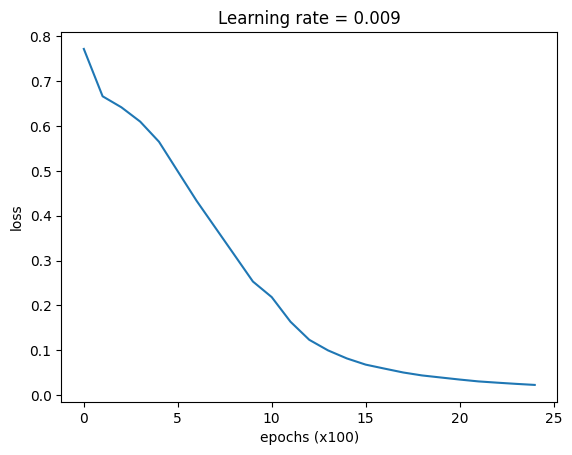

Number of trainable parameters: 258345


In [29]:
(X_train, Y_train), (X_test, Y_test), classes = load_dataset('datasets/catsvsnoncats.h5')
np.random.seed(2019)
model = deep_model(X_train, Y_train, X_test, Y_test, hidden_layers=[21, 9, 7], learning_rate=0.009)

plt.plot(model["LOSS"])
plt.ylabel('loss')
plt.xlabel('epochs (x100)')
plt.title("Learning rate = {}".format(model["LR"]))
plt.show()

params = model["PARAMS"]
parameter_count = 0
for key in params.keys():
    parameter_count = parameter_count + np.prod(params[key].shape)
print("Number of trainable parameters: {}".format(parameter_count))